# Solve for transition path in Ramsey-model

**Table of contents**<a id='toc0_'></a>    
- 1. [Univariate](#toc1_)    
- 2. [Multivariate](#toc2_)    
- 3. [Set parameters](#toc3_)    
- 4. [Calculate steady state](#toc4_)    
- 5. [Truncated equation system](#toc5_)    
- 6. [Jacobian](#toc6_)    
- 7. [Find transition path](#toc7_)    
  - 7.1. [Low initial capital](#toc7_1_)    
  - 7.2. [Technology shock](#toc7_2_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

This notebok shows how to solve the Ramsey model in sequence space.

In [1]:
%load_ext autoreload
%autoreload 2

import time
import pickle
import numpy as np
from scipy import optimize

import matplotlib.pyplot as plt   
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams.update({"axes.grid" : True, "grid.color": "black", "grid.alpha":"0.25", "grid.linestyle": "--"})
plt.rcParams.update({'font.size': 14})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Intro: Newton's method

## 1. <a id='toc1_'></a>[Univariate](#toc0_)

Let's say we want to find the root of the function $y=e^{-0.5x}-2.$ That is, we want to find an $x$ such that $e^{-0.5x}-2=0.$

Of course, we could simply do it analytically $x = -2\ln(2)$ but let's say we want to check this numerically. 

In [2]:
def f(x):
    y = np.exp(-0.5*x) - 2.
    return y 

Using the formula for the derivative, we can approximate it numerically as 
$$f'(x)\approx \frac{f(x+h)-f(x)}{h}\quad \text{for some small }h$$

In [3]:
h = 1e-05 
def fprime(x,h):
    return (f(x+h) - f(x)) / h

Solve using Newton's method, guessing an $x^0$, and then iterating over this mapping
$$x^{n+1}=x^n - \frac{f(x^n)}{f'(x^n}$$

In [5]:
# Initial guess 
x = 0.1 

# Newton loop 
for j in range(50):

    # check if zero
    error = f(x)

    print(f'Current error: {error:.6f}')
    if np.abs(error) < 1e-10:
        
        print(f'Converged after {j} iterations')
        break 

    else:

        x_plus = x - f(x)/fprime(x,h) 
        x = x_plus

Current error: -1.048771
Current error: 0.864933
Current error: 0.118357
Current error: 0.003245
Current error: 0.000003
Current error: -0.000000
Converged after 5 iterations


f(x) = 0 has an analytical solution, so check that we get the correct solution with Newton's method 

In [6]:
x_analytical = np.log(2.) / -0.5
print(f'Newton solution: {x:.5f}')
print(f'Analytical solution: {x_analytical:.5f}')

Newton solution: -1.38629
Analytical solution: -1.38629


## 2. <a id='toc2_'></a>[Multivariate](#toc0_)

In [7]:
def f(x):
    y = np.zeros(2)
    y[0] = 4 * x[0]**0.3 * x[1]**0.55 - 2.
    y[1] = 1 * x[0] - 0.5 * x[1]
    return y 

In the multivariate case, we use the following algorithm
$$\mathbf{x}^{n+1}=\mathbf{x}^n - \frac{f(\mathbf{x})}{\nabla f(\mathbf{x}^n)}$$
where $f(\mathbf{x})$ takes a vector and outputs a vector (or a number).
where $$\nabla f(\mathbf{x})
\;=\;
J_f(\mathbf{x})
\;=\;
\begin{bmatrix}
\dfrac{\partial f_1}{\partial x_1}(\mathbf{x}) & \dfrac{\partial f_1}{\partial x_2}(\mathbf{x}) & \cdots & \dfrac{\partial f_1}{\partial x_n}(\mathbf{x}) \\
\dfrac{\partial f_2}{\partial x_1}(\mathbf{x}) & \dfrac{\partial f_2}{\partial x_2}(\mathbf{x}) & \cdots & \dfrac{\partial f_2}{\partial x_n}(\mathbf{x}) \\
\vdots & \vdots & \ddots & \vdots \\
\dfrac{\partial f_m}{\partial x_1}(\mathbf{x}) & \dfrac{\partial f_m}{\partial x_2}(\mathbf{x}) & \cdots & \dfrac{\partial f_m}{\partial x_n}(\mathbf{x})
\end{bmatrix}.$$ is the Jacobian matrix.

In [9]:
def Jac(x, index, h):
    h_ = np.zeros(2)
    h_[index] = h
    return (f(x+h_) - f(x)) / h

Solve

In [10]:
f(x)

array([ 0.11264229, -0.45      ])

In [11]:
# Initial guess 
x = np.array([0.1,1.1])

# Newton loop 
for j in range(50):
    
    # check if zero
    error = f(x)
    print(f'Current max error: {np.max(error):.9f}')

    if np.max(np.abs(error)) < 1e-09:

        print(f'Converged after {j} iterations')

        break 
    
    else:

        # Jacobian 
        J = np.zeros((2,2))
        J[:,0] = Jac(x,0,h)
        J[:,1] = Jac(x,1,h)

        # Update 
        x_plus = x - np.linalg.inv(J) @ f(x) # Note: More efficient to use np.linalg.solve than np.linalg.inv 
        x = x_plus 

Current max error: 0.112642286
Current max error: -0.000000000
Current max error: 0.000000000
Current max error: -0.000000000
Current max error: 0.000000000
Converged after 4 iterations


In [12]:
x_analytical = np.zeros(2)
x_analytical[1] = ((2. / 4.) / 0.5**0.3)**(1/(0.3+0.55)) 
x_analytical[0] = 0.5 * x_analytical[1]

print(f'Newton solution: {x[0]:.6f}, {x[1]:.6f}')
print(f'Analytical solution: {x_analytical[0]:.6f}, {x_analytical[1]:.6f}')

Newton solution: 0.282529, 0.565058
Analytical solution: 0.282529, 0.565058


Sometimes, recomputing the Jacobian is costly so we can use Broyden's method instead where we update the Jacobian using a rule.

In [38]:
# Initial guess 
x_broyden = np.array([0.1,1.1])

# J around initial point 
J = np.zeros((2,2))
J[:,0] = Jac(x_broyden,0,h)
J[:,1] = Jac(x_broyden,1,h)

# Newton loop 
for j in range(50):

    # check if zero
    error = f(x_broyden)
    print(f'Current max error: {np.max(error):.6f}')

    if np.max(np.abs(error)) < 1e-09:

        print(f'Converged after {j} iterations')

        break 
    
    else:

        # Broyden update 
        if j > 1:
            dy = f(x_broyden) - f(x_old)
            dx = x_broyden - x_old
            J = J + np.outer(((dy - J @ dx) / np.linalg.norm(dx) ** 2), dx)

        # Newton update 
        x_broyden_plus = x_broyden - np.linalg.inv(J) @ f(x_broyden)

        # save old for J update 
        x_old = x_broyden 

        x_broyden = x_broyden_plus # update current guess x 

Current max error: 0.112642
Current max error: -0.000000
Current max error: 0.000000
Current max error: 0.000000
Current max error: 0.000000
Current max error: 0.000000
Current max error: 0.000000
Converged after 6 iterations


Check that we got same solution

In [39]:
assert all(np.isclose(x, x_broyden))

# Ramsey model

## 3. <a id='toc3_'></a>[Set parameters](#toc0_)

In [13]:
Gamma_ss = 1.0
alpha = 0.36
beta = 0.96
delta = 0.10
sigma = 2.0

## 4. <a id='toc4_'></a>[Calculate steady state](#toc0_)

Quantities:

In [14]:
K_ss = ((1/beta-1+delta)/(Gamma_ss*alpha))**(1/(alpha-1))
C_hh_ss = (1-delta)*K_ss+Gamma_ss*K_ss**alpha-K_ss

print(f'{K_ss = :.4f}')
print(f'{C_hh_ss = :.4f}')

K_ss = 4.2940
C_hh_ss = 1.2604


In [15]:
def rK_func(Gamma,K_lag):
    return Gamma*alpha*K_lag**(alpha-1)

def w_func(Gamma,K_lag):
    return Gamma*(1-alpha)*K_lag**(alpha)

Prices:

In [16]:
rK_ss = rK_func(Gamma_ss,K_ss)
r_ss = rK_ss-delta
w_ss = w_func(Gamma_ss,K_ss)

print(f'{rK_ss = :.4f}')
print(f'{r_ss = :.4f}')
print(f'{w_ss = :.4f}')

rK_ss = 0.1417
r_ss = 0.0417
w_ss = 1.0815


## 5. <a id='toc5_'></a>[Truncated equation system](#toc0_)

In [19]:
T = 200 # length of truncation

In [20]:
def H(K,Gamma,K_lag_ini,C_hh_ss,T):

    # initial / pre-determined: K_ini
    # steady state: C_hh_ss

    # shocks: Gamma
    # endogenous: K

    # truncation length T

    # a. allocate
    rK = np.zeros(T)
    w = np.zeros(T)
    C_hh = np.zeros(T)
    A_hh = np.zeros(T)

    # block 1: production firm [K_lag_ini,K -> rK,w]
    for t in range(T):

        if t == 0:
            K_lag = K_lag_ini
        else:
            K_lag = K[t-1]

        rK[t] = rK_func(Gamma[t],K_lag)
        w[t] = w_func(Gamma[t],K_lag)

    # block 2: mutual fund: K,rK -> A,r
    A = K
    r = rK-delta

    # block 3: household [K_lag_ini,r,w->C,A_hh]
    for t in reversed(range(T)): # backwards on Euler

        #t = T-1-k

        if t == T-1:  
            C_hh_plus = C_hh_ss 
            r_plus = r_ss 
        else:
            C_hh_plus = C_hh[t+1]
            r_plus = r[t+1]

        C_hh[t] = (beta*(1+r_plus))**(-1/sigma)*C_hh_plus

    for t in range(T): # forwards on budget constraint

        if t == 0:
            A_hh_lag = K_lag_ini # previous clearing
        else:
            A_hh_lag = A_hh[t-1]

        A_hh[t] = (1+r[t])*A_hh_lag + w[t] - C_hh[t]        
    
    # block 4: market clearing
    clearing_A = A-A_hh
    return clearing_A,C_hh

Test errors are zero with steady state input:

In [21]:
K_vec = np.repeat(K_ss,T)
Gamma_vec = np.repeat(Gamma_ss,T)
errors,_ = H(K_vec,Gamma_vec,K_ss,C_hh_ss,T)
assert np.allclose(errors,0) 

In [22]:
errors 

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

## 6. <a id='toc6_'></a>[Jacobian](#toc0_)

In [57]:
def calc_jac(T,Delta=1e-12):
    
    jac = np.zeros((T,T))

    for s in range(T):

        K = np.repeat(K_ss,T)
        K[s] += Delta

        errors,_ = H(K, np.repeat(Gamma_ss,T), K_ss, C_hh_ss, T)
        jac[:,s] = errors/Delta # Should subtract steady state error here, but zero by construction

    return jac

In [58]:
jac = calc_jac(T)

In [59]:
jac.shape

(200, 200)

## 7. <a id='toc7_'></a>[Find transition path](#toc0_)

In [60]:
from GEModelTools import broyden_solver

In [61]:
def obj(x):
    errors,_ = H(x, Gamma_path, K_ini,C_hh_ss,T)
    return errors

### 7.1. <a id='toc7_1_'></a>[Low initial capital](#toc0_)

In [62]:
Gamma_path = np.repeat(Gamma_ss,T)
K_ini = K_ss *0.75

K_path_guess = np.repeat(K_ss,T)
K_path = broyden_solver(obj,K_path_guess,jac,do_print=True)
_,C_hh_path = H(K_path,Gamma_path,K_ini,C_hh_ss,T)

 it =   0 -> max. abs. error = 3.82e+03
 it =   1 -> max. abs. error = 2.05e+02
 it =   2 -> max. abs. error = 2.61e+01
 it =   3 -> max. abs. error = 6.76e-01
 it =   4 -> max. abs. error = 4.07e-01
 it =   5 -> max. abs. error = 2.96e-02
 it =   6 -> max. abs. error = 8.83e-04
 it =   7 -> max. abs. error = 3.84e-04
 it =   8 -> max. abs. error = 2.50e-05
 it =   9 -> max. abs. error = 1.73e-06
 it =  10 -> max. abs. error = 4.10e-07
 it =  11 -> max. abs. error = 1.88e-08
 it =  12 -> max. abs. error = 2.44e-09


In [63]:
K_path.shape 

(200,)

In [64]:
error,C_hh_path = H(K_path,Gamma_path,K_ini,C_hh_ss,T)

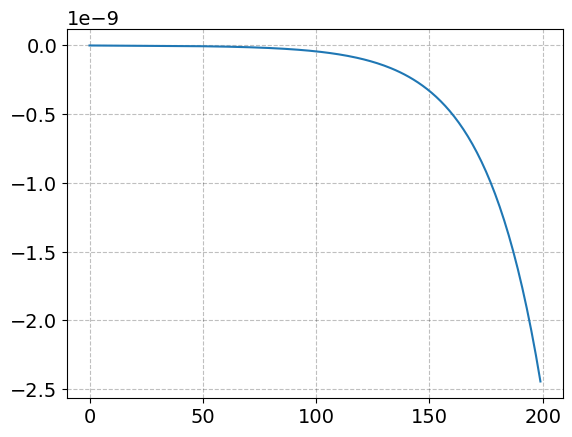

In [65]:
plt.plot(error)

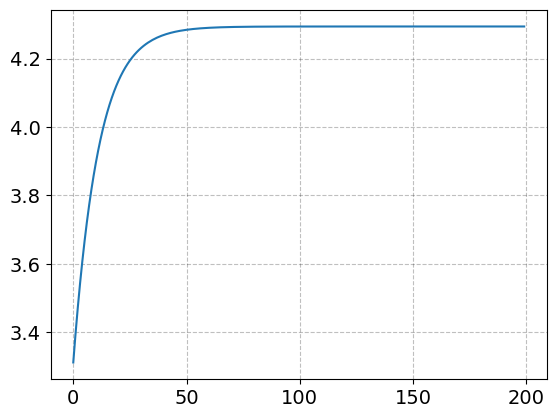

In [66]:
plt.plot(K_path)

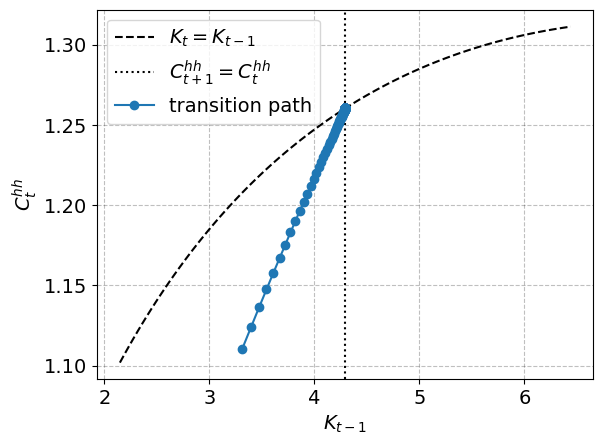

In [67]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

K_lag = np.linspace(K_ss/2,K_ss*1.5,100)

K_constant = (1-delta)*K_lag+Gamma_ss*K_lag**alpha-K_lag
ax.plot(K_lag,K_constant,ls='--',label='$K_{t}=K_{t-1}$',color='black')
ax.axvline(K_ss,ls=':',label='$C^{hh}_{t+1}=C^{hh}_t$',color='black')

ax.plot(K_path,C_hh_path,'-o',label='transition path')

ax.set_xlabel('$K_{t-1}$')
ax.set_ylabel('$C^{hh}_{t}$')
ax.legend(frameon=True)
# fig.savefig('figs/K_ini_lag.pdf')

### 7.2. <a id='toc7_2_'></a>[Technology shock](#toc0_)

In [68]:
Gamma_path = Gamma_ss + 0.01*Gamma_ss*0.95**np.arange(T)

In [69]:
K_path_guess = np.repeat(K_ss,T)

In [70]:
K_path_guess

array([4.2940482, 4.2940482, 4.2940482, 4.2940482, 4.2940482, 4.2940482,
       4.2940482, 4.2940482, 4.2940482, 4.2940482, 4.2940482, 4.2940482,
       4.2940482, 4.2940482, 4.2940482, 4.2940482, 4.2940482, 4.2940482,
       4.2940482, 4.2940482, 4.2940482, 4.2940482, 4.2940482, 4.2940482,
       4.2940482, 4.2940482, 4.2940482, 4.2940482, 4.2940482, 4.2940482,
       4.2940482, 4.2940482, 4.2940482, 4.2940482, 4.2940482, 4.2940482,
       4.2940482, 4.2940482, 4.2940482, 4.2940482, 4.2940482, 4.2940482,
       4.2940482, 4.2940482, 4.2940482, 4.2940482, 4.2940482, 4.2940482,
       4.2940482, 4.2940482, 4.2940482, 4.2940482, 4.2940482, 4.2940482,
       4.2940482, 4.2940482, 4.2940482, 4.2940482, 4.2940482, 4.2940482,
       4.2940482, 4.2940482, 4.2940482, 4.2940482, 4.2940482, 4.2940482,
       4.2940482, 4.2940482, 4.2940482, 4.2940482, 4.2940482, 4.2940482,
       4.2940482, 4.2940482, 4.2940482, 4.2940482, 4.2940482, 4.2940482,
       4.2940482, 4.2940482, 4.2940482, 4.2940482, 

In [71]:

K_lag_ini = K_ss 
Gamma = Gamma_path 
K = K_path_guess

# a. allocate
rK = np.zeros(T)
w = np.zeros(T)
C_hh = np.zeros(T)
A_hh = np.zeros(T)

# block 1: production firm [K_lag_ini,K -> rK,w]
for t in range(T):

    if t == 0:
        K_lag = K_lag_ini
    else:
        K_lag = K[t-1]

    rK[t] = rK_func(Gamma[t],K_lag)
    w[t] = w_func(Gamma[t],K_lag)

# block 2: mutual fund: K,rK -> A,r
A = K
r = rK-delta

# block 3: household [K_lag_ini,r,w->C,A_hh]
for t in reversed(range(T)): # backwards on Euler

    #t = T-1-k

    if t == T-1:  
        C_hh_plus = C_hh_ss 
        r_plus = r_ss 
    else:
        C_hh_plus = C_hh[t+1]
        r_plus = r[t+1]

    C_hh[t] = (beta*(1+r_plus))**(-1/sigma)*C_hh_plus

for t in range(T): # forwards on budget constraint

    if t == 0:
        A_hh_lag = K_lag_ini # previous clearing
    else:
        A_hh_lag = A_hh[t-1]

    A_hh[t] = (1+r[t])*A_hh_lag + w[t] - C_hh[t]        



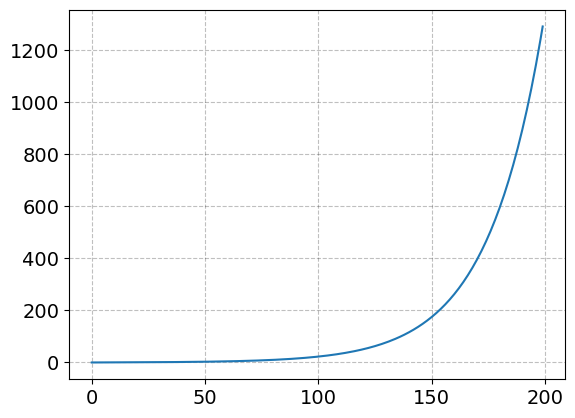

In [72]:
plt.plot(A_hh - K)

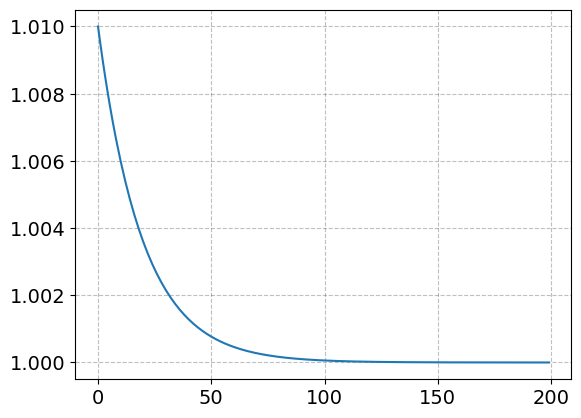

In [73]:
plt.plot(Gamma_path)

In [74]:

K_ini = K_ss

def obj(x):
    errors,C = H(x,Gamma_path,K_ini,C_hh_ss,T)
    return errors

K_path_guess = np.repeat(K_ss,T)
K_path = broyden_solver(obj,K_path_guess,jac,do_print=True)
_,C_hh_path = H(K_path,Gamma_path,K_ini,C_hh_ss,T)

 it =   0 -> max. abs. error = 1.29e+03
 it =   1 -> max. abs. error = 3.40e+00
 it =   2 -> max. abs. error = 4.84e-01
 it =   3 -> max. abs. error = 1.53e-02
 it =   4 -> max. abs. error = 2.92e-04
 it =   5 -> max. abs. error = 2.43e-06
 it =   6 -> max. abs. error = 6.20e-08
 it =   7 -> max. abs. error = 3.40e-09


<>:5: SyntaxWarning: invalid escape sequence '\G'
<>:5: SyntaxWarning: invalid escape sequence '\G'
/var/folders/hn/dsqvtr1n09z9k135wwh_g7280000gn/T/ipykernel_72137/38199575.py:5: SyntaxWarning: invalid escape sequence '\G'
  ax.set_title('$\Gamma_{t}$')


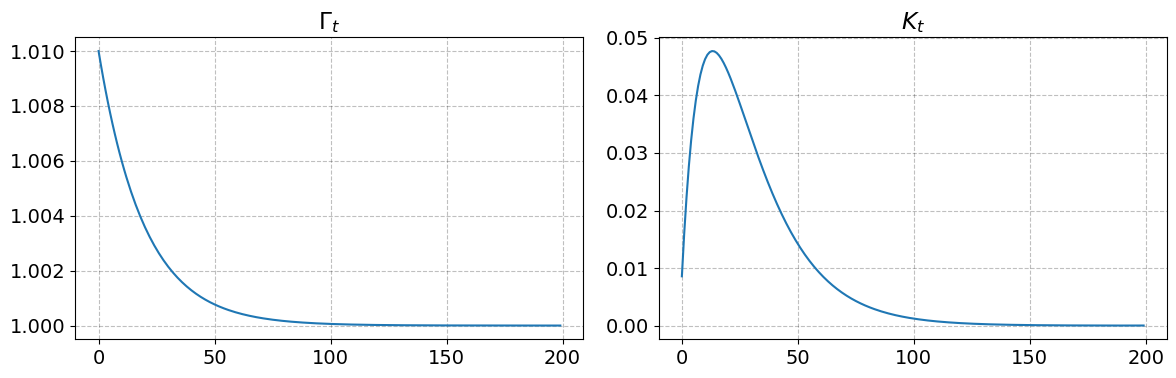

In [75]:
fig = plt.figure(figsize=(12,4))

ax = fig.add_subplot(1,2,1)
ax.plot(np.arange(T),Gamma_path)
ax.set_title('$\Gamma_{t}$')

ax = fig.add_subplot(1,2,2)
ax.plot(np.arange(T),K_path - K_ss)
ax.set_title('$K_{t}$')

fig.tight_layout()